In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler



## **Read the data** :

In [32]:

drive.mount('/content/drive')

data=pd.read_csv("/content/drive/MyDrive/Portfolio/Customer Segmentation | Clustering (Unsupervised Learning)/Mall_Customers.csv")
data.head(6)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [34]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


## ***I. Exploratory Data Analysis*** :


## Missing Values :

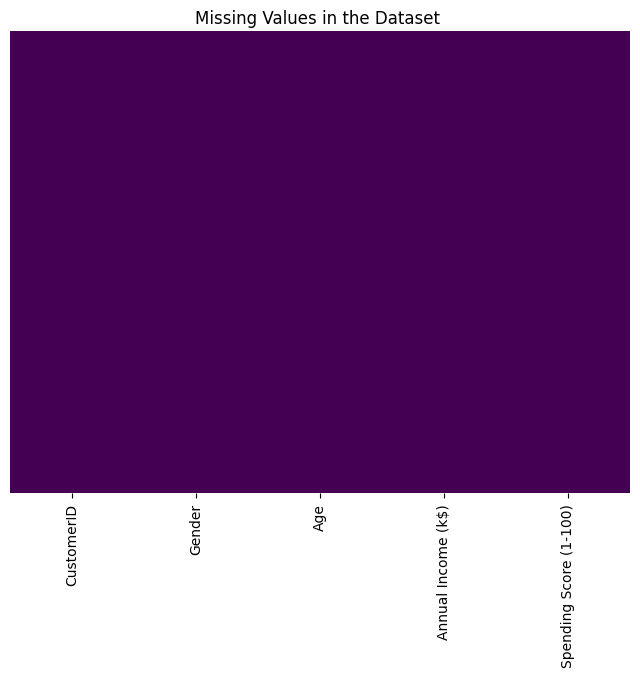

In [35]:
# Plot missing values
plt.figure(figsize=(8, 6))
sns.heatmap(data.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Missing Values in the Dataset ')
plt.show()

## Gender :

Text(0.5, 1.0, 'Gender Distribution ')

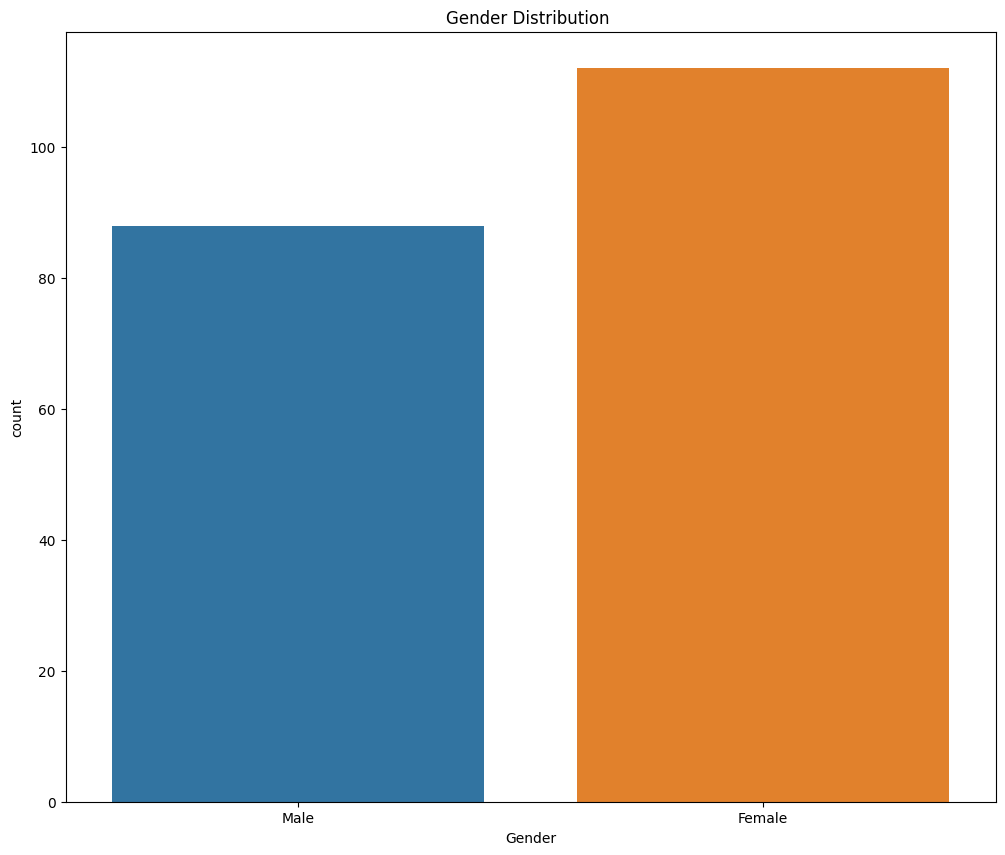

In [36]:
# Plot Gender Distribution
plt.figure(figsize=(12, 10))
sns.countplot(x='Gender', data=data,)
plt.title(f'Gender Distribution ')

## Age :

Text(0.5, 1.0, 'Age Distribution with Density')

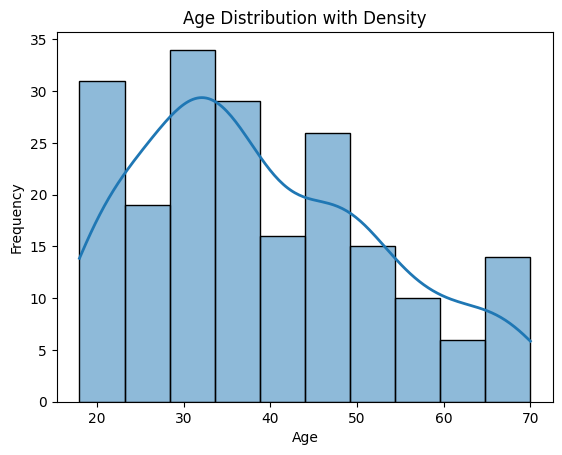

In [37]:
# Plot distribution of Age

sns.histplot(data['Age'], kde=True, bins=10, line_kws={'linewidth': 2})


plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution with Density')

## Annual Income :

Text(0.5, 1.0, 'Annual_Income Distribution with Density')

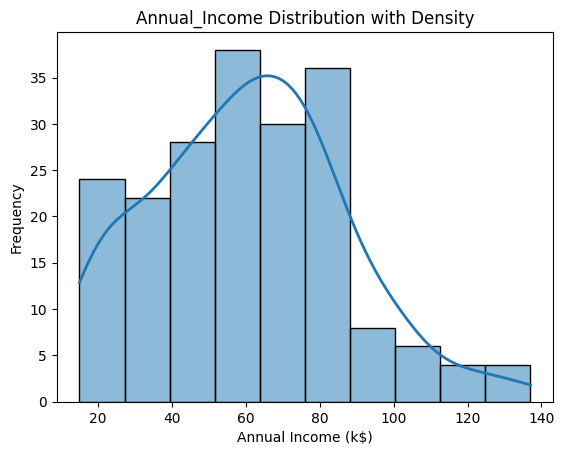

In [38]:
# Plot distribution of Annual_Income

sns.histplot(data['Annual Income (k$)'], kde=True, bins=10, line_kws={'linewidth': 2})


plt.xlabel('Annual Income (k$)')
plt.ylabel('Frequency')
plt.title('Annual_Income Distribution with Density')

## **Spending Score** :

Text(0.5, 1.0, 'Spending Score Distribution with Density')

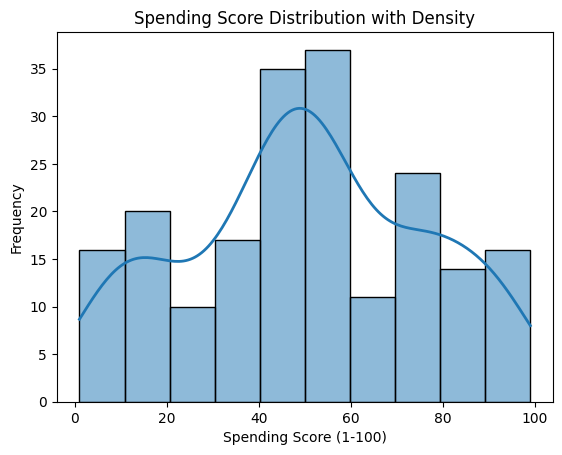

In [39]:
# Plot distribution of Spending Score

sns.histplot(data['Spending Score (1-100)'], kde=True, bins=10, line_kws={'linewidth': 2})


plt.xlabel('Spending Score (1-100)')
plt.ylabel('Frequency')
plt.title('Spending Score Distribution with Density')


## **Pair Plot** :

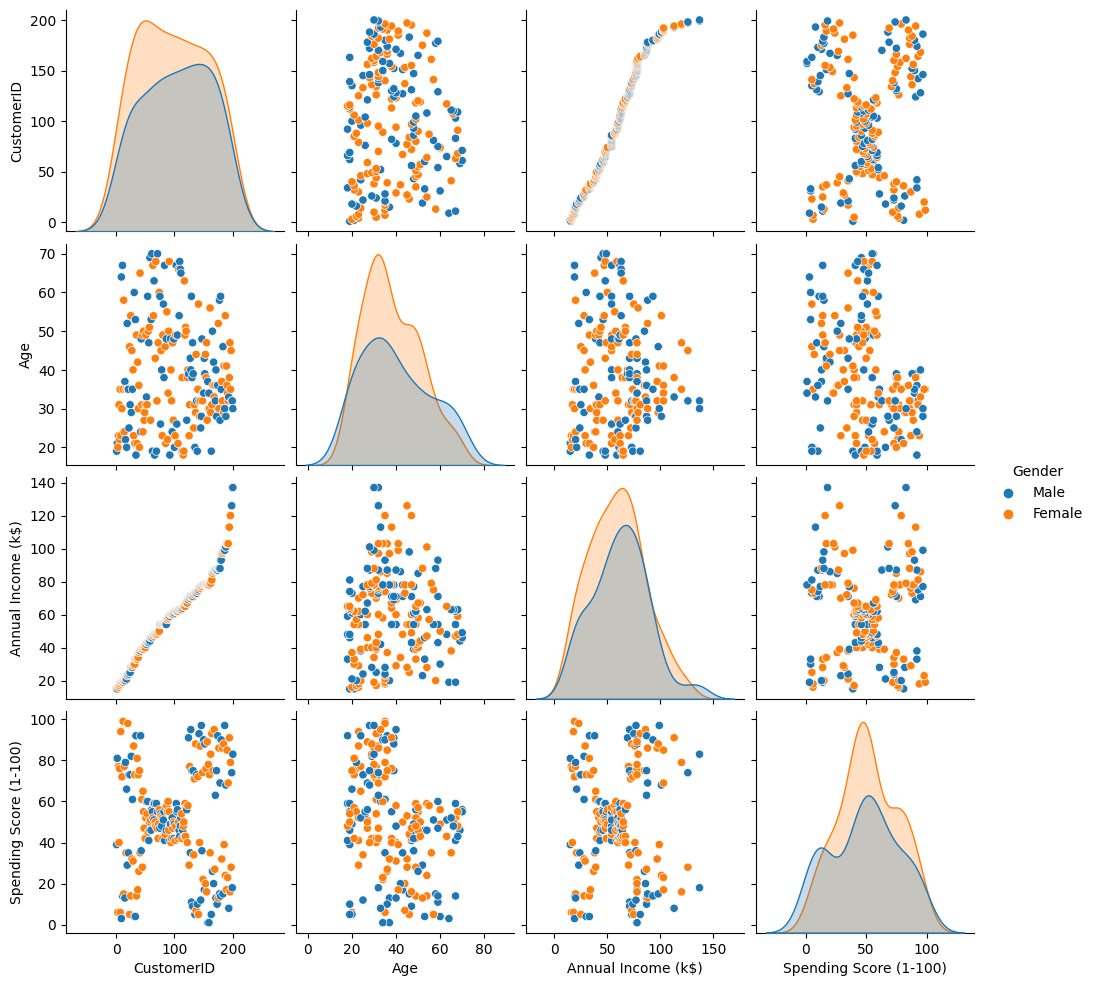

In [40]:
# Pairplot to visualize the relationships and distributions
sns.pairplot(data, hue="Gender")
plt.show()

## **3D scatter plot of the numerical variables** :

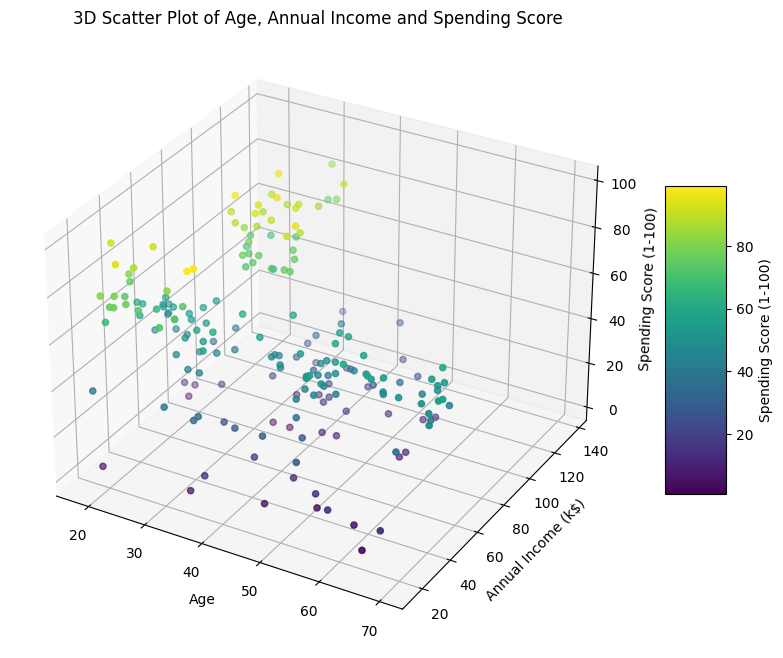

In [41]:
from mpl_toolkits.mplot3d import Axes3D

# Creating a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting data
scatter = ax.scatter(data['Age'], data['Annual Income (k$)'], data['Spending Score (1-100)'],
                     c=data['Spending Score (1-100)'], cmap='viridis', marker='o')

# Adding labels and title
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D Scatter Plot of Age, Annual Income and Spending Score')

# Adding color bar
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Spending Score (1-100)')

# Showing the plot
plt.show()

## **Coorelation Matrix** :  

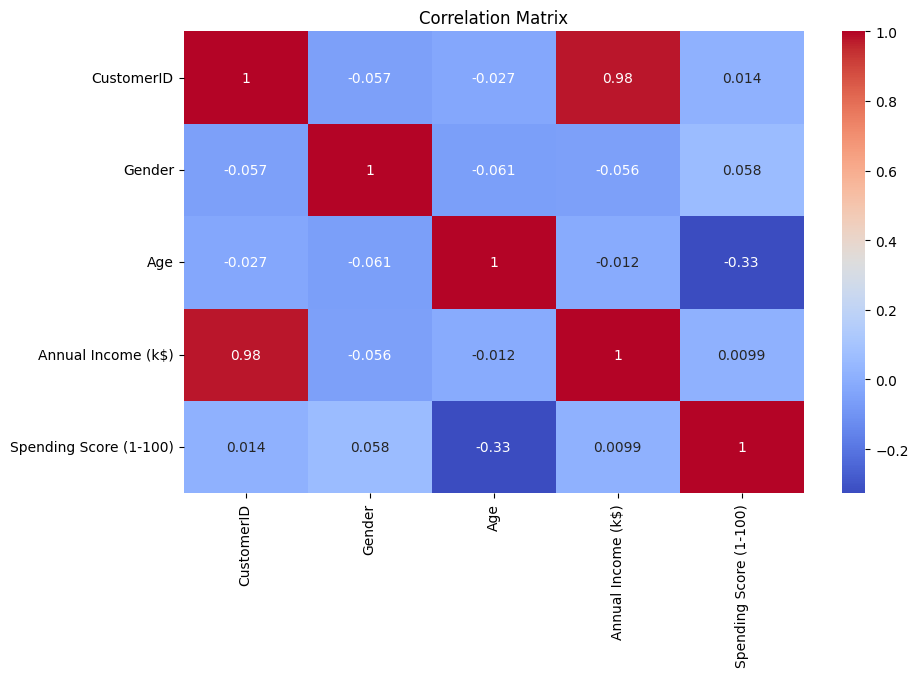

In [42]:
# Converting 'Gender' from categorical to numerical for correlation analysis
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})

# Calculating correlations
correlation_matrix = data.corr()

# Plotting correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# ***II. Clustering*** :


---



---



## **Scale the Data** :

In [43]:


# Selecting features for clustering
X = data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Rescaling the data
min_max_scaler = MinMaxScaler()
X_scaled_min_max = min_max_scaler.fit_transform(X)

# Converting the scaled data back to a DataFrame for easier handling
X_scaled = pd.DataFrame(X_scaled_min_max, columns=X.columns)


X_scaled.head(5)

,Age,Annual Income (k$),Spending Score (1-100)
0,0.019231,0.000000,0.387755
1,0.057692,0.000000,0.816327
2,0.038462,0.008197,0.051020
3,0.096154,0.008197,0.775510
4,0.250000,0.016393,0.397959


## **clustring plot function** :

In [45]:

# Function to plot clustering results and silhouette scores
def plot_clustering_results_2D(X, clusterer, algorithm_name, params, axs):
    silhouette_scores = {}
    for i, param in enumerate(params):
        # Adjusting the clusterer based on the algorithm type
        if isinstance(clusterer, KMeans) or isinstance(clusterer, AgglomerativeClustering) or isinstance(clusterer, SpectralClustering):
            clusterer.n_clusters = param
        elif isinstance(clusterer, DBSCAN):
            clusterer.eps = param

        # Fitting the clusterer to the data
        cluster_labels = clusterer.fit_predict(X)
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

        # Scatter plot of clustering results
        axs[i, 0].scatter(X['Annual Income (k$)'], X['Spending Score (1-100)'], c=cluster_labels, cmap='viridis')
        axs[i, 0].set_title(f'{algorithm_name} (eps={param})')
        axs[i, 0].set_xlabel('Annual Income (k$)')
        axs[i, 0].set_ylabel('Spending Score (1-100)')

        # Silhouette scores - only meaningful if n_clusters > 1
        if n_clusters > 1:
            silhouette_avg = silhouette_score(X, cluster_labels)
            silhouette_scores[param] = silhouette_avg
            sample_silhouette_values = silhouette_samples(X, cluster_labels)

            y_lower = 10
            for j in range(n_clusters):
                # Aggregate the silhouette scores for samples belonging to cluster j, and sort them
                ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
                ith_cluster_silhouette_values.sort()
                size_cluster_j = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_j

                color = cm.nipy_spectral(float(j) / n_clusters)
                axs[i, 1].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
                y_lower = y_upper + 10

            # Silhouette plot
            axs[i, 1].set_title("Silhouette Plot")
            axs[i, 1].set_xlabel("Silhouette Coefficient")
            axs[i, 1].set_ylabel("Cluster Label")
            axs[i, 1].axvline(x=silhouette_avg, color="red", linestyle="--")
            axs[i, 1].text(silhouette_avg + 0.02, axs[i, 1].get_ylim()[1] * 0.9, f'avg={silhouette_avg:.2f}')

    return silhouette_scores


## **1. K-means** :

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

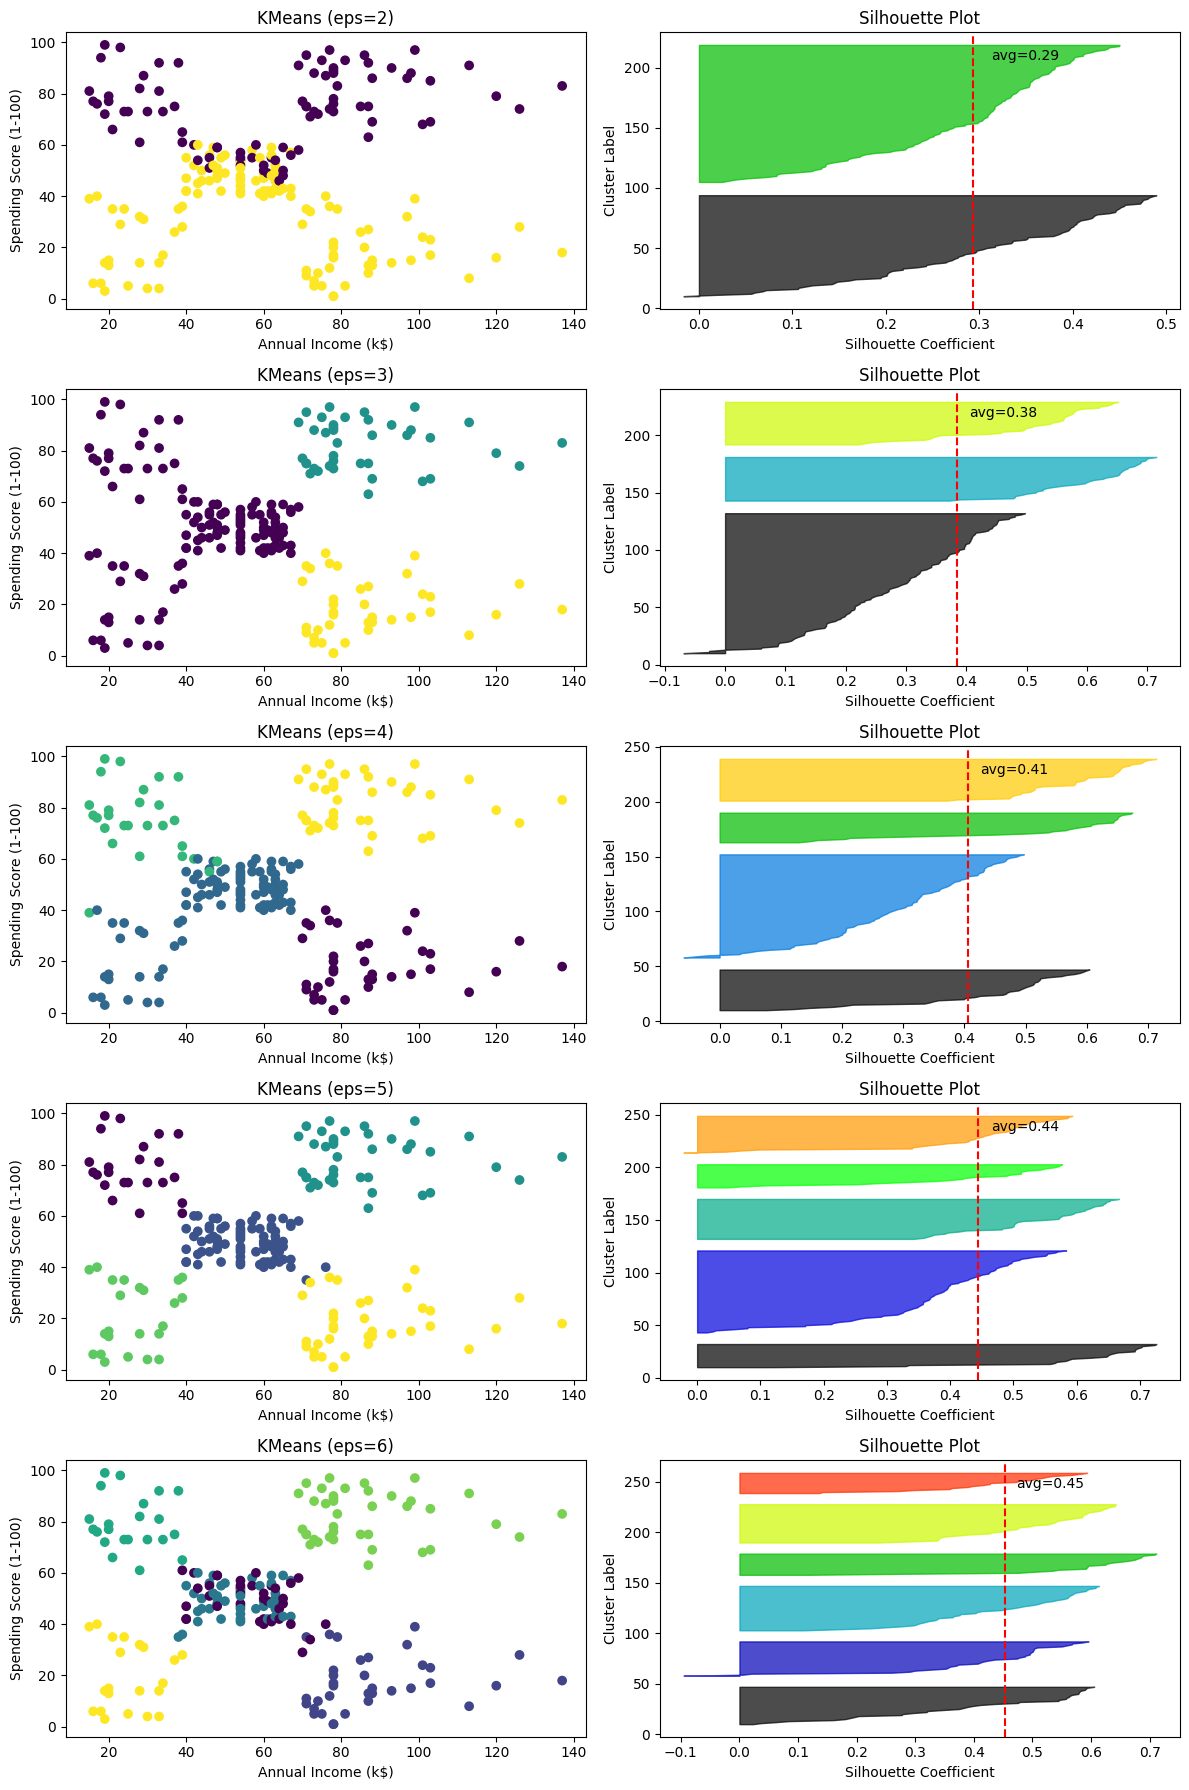

{2: 0.293166070535953, 3: 0.3839349967742105, 4: 0.40546302077733304, 5: 0.44428597560893024, 6: 0.4523443947724053}


In [46]:



# Range of parameters to try for silhouette scores
# For KMeans, AgglomerativeClustering, and SpectralClustering, this will be n_clusters
# For DBSCAN, this will be eps values
kmeans_params = [2, 3, 4, 5, 6]


# Setting up the figure for plots
fig, axs = plt.subplots(len(kmeans_params), 2, figsize=(12, 18))

# Clustering algorithms initialization
# Example with KMeans
kmeans = KMeans(random_state=10)
# Example with DBSCAN
dbscan = DBSCAN(min_samples=5)

# Analyzing the chosen clustering algorithm
# Replace kmeans with dbscan or any other initialized clusterer, and kmeans_params with dbscan_params if needed
silhouette_scores = plot_clustering_results_2D(X, kmeans, 'KMeans', kmeans_params, axs)

plt.tight_layout()
plt.show()

# Displaying silhouette scores
print(silhouette_scores)


## **2. Spectral Clustering** :

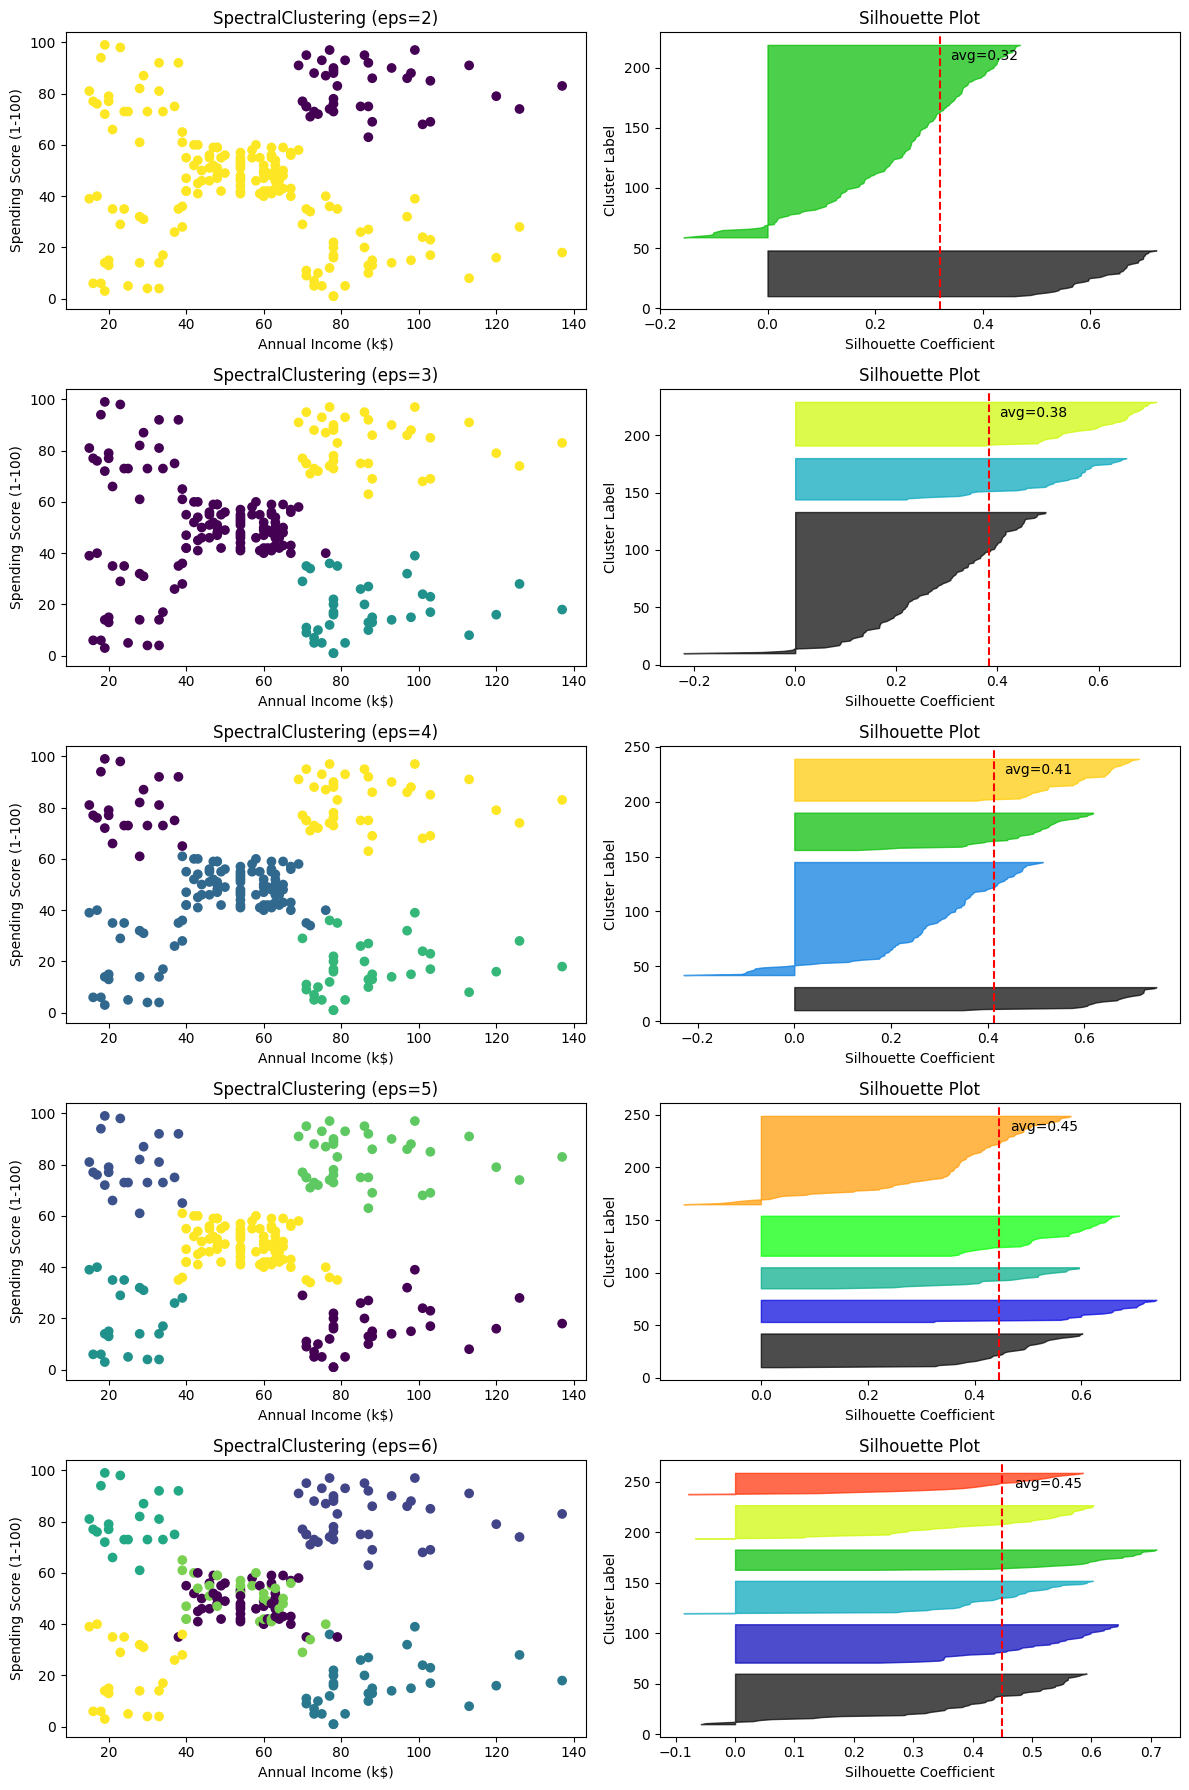

{2: 0.32058294097344175, 3: 0.38308598792855264, 4: 0.41290211256460574, 5: 0.4462933997368269, 6: 0.4500527434285387}


In [47]:
# Parameters for SpectralClustering
SpectralClustering_params = [2, 3, 4, 5, 6]

# Setting up the figure for plots
fig, axs = plt.subplots(len(SpectralClustering_params), 2, figsize=(12, 18))

# Initializing the SpectralClustering model
SpectralClustering_model = SpectralClustering(affinity='nearest_neighbors')

# Analyzing SpectralClustering with different numbers of clusters
silhouette_scores_spectral = plot_clustering_results_2D(X, SpectralClustering_model, 'SpectralClustering', SpectralClustering_params, axs)

plt.tight_layout()
plt.show()

# Displaying silhouette scores for SpectralClustering
print(silhouette_scores_spectral)


## **3. Aggolmerative Clustering** :

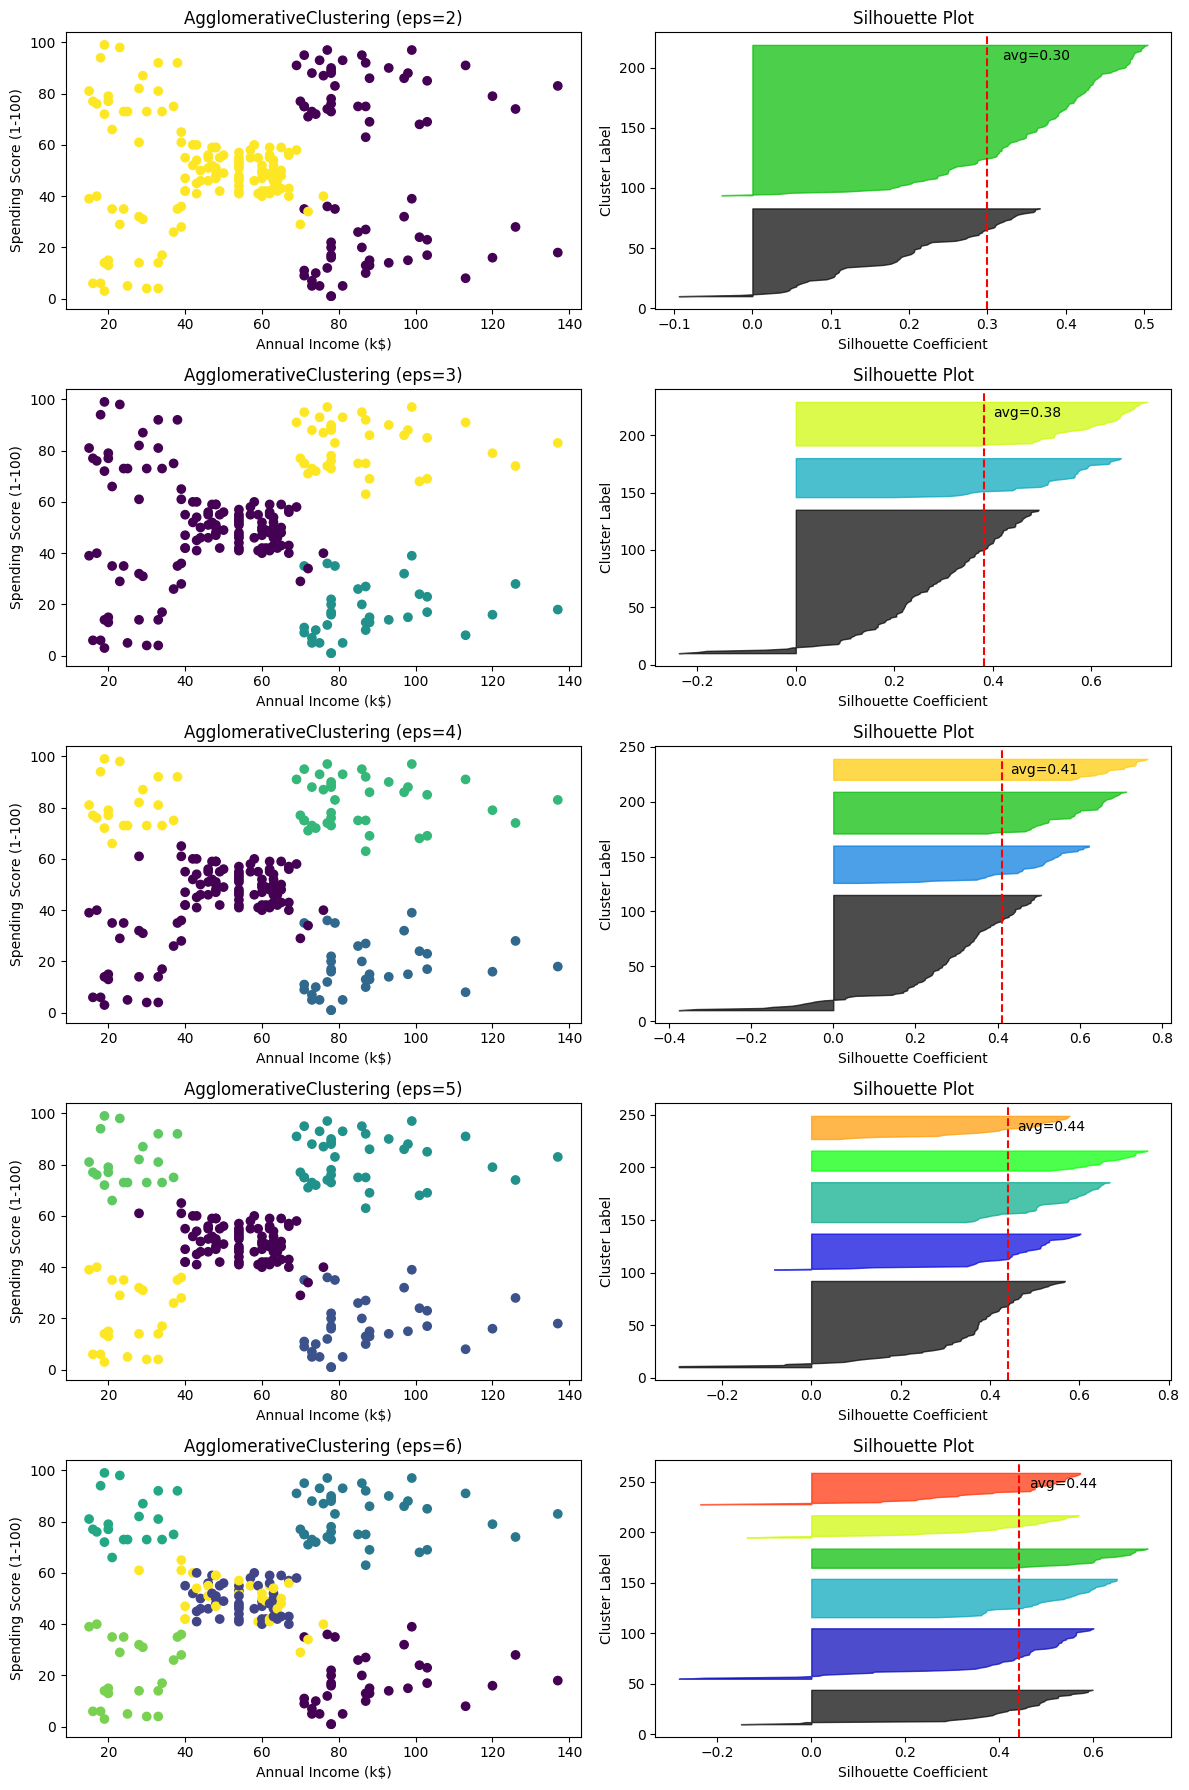

{2: 0.2992593203550994, 3: 0.38141795042544546, 4: 0.41037986351850747, 5: 0.4401889024290193, 6: 0.44308912983504156}


In [48]:

# Range of number of clusters to try for AgglomerativeClustering
agglomerative_params = [2, 3, 4, 5, 6]

# Setting up the figure for plots
fig, axs = plt.subplots(len(agglomerative_params), 2, figsize=(12, 18))

# AgglomerativeClustering clusterer initialization
agglomerative = AgglomerativeClustering()

# Analyzing AgglomerativeClustering with different number of clusters
silhouette_scores_agglomerative = plot_clustering_results_2D(X, agglomerative, 'AgglomerativeClustering', agglomerative_params, axs)

plt.tight_layout()
plt.show()

# Displaying silhouette scores for AgglomerativeClustering
print(silhouette_scores_agglomerative)



## **3D Comparative plot of the Clustering Algorithms** :

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


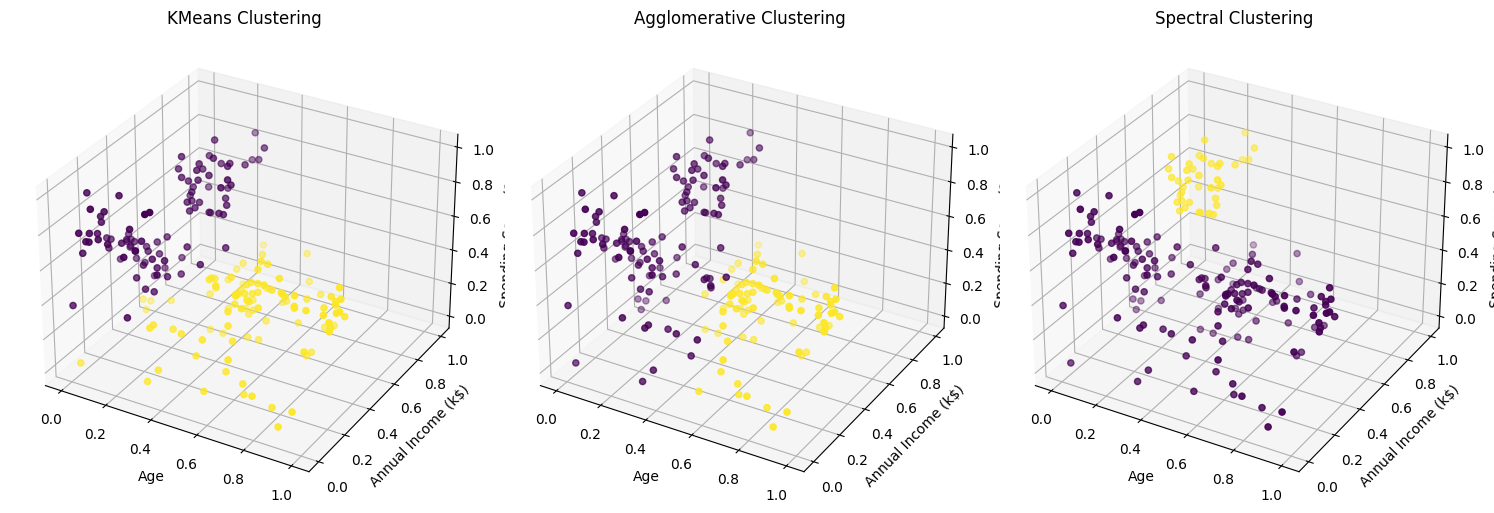

In [56]:
clustering_algorithms = {
    'KMeans': KMeans(n_clusters=2),
    'Agglomerative': AgglomerativeClustering(n_clusters=2),
    'Spectral': SpectralClustering(n_clusters=2, affinity='nearest_neighbors')
}

# Applying each clustering algorithm and storing results
cluster_labels = {}
silhouette_scores = {}

for name, algorithm in clustering_algorithms.items():
    labels = algorithm.fit_predict(X_scaled)
    cluster_labels[name] = labels
    # Silhouette score is only meaningful if there are 2 or more clusters
    if len(np.unique(labels)) > 1:
        silhouette_scores[name] = silhouette_score(X_scaled, labels)

# Plotting results for each clustering algorithm
fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'})
axs = axs.flatten()

for ax, (name, labels) in zip(axs, cluster_labels.items()):
    ax.scatter(X_scaled['Age'], X_scaled['Annual Income (k$)'], X_scaled['Spending Score (1-100)'], c=labels, cmap='viridis')
    ax.set_title(f'{name} Clustering')
    ax.set_xlabel('Age')
    ax.set_ylabel('Annual Income (k$)')
    ax.set_zlabel('Spending Score (1-100)')

# Showing the plots
plt.tight_layout()
plt.show()



In [ ]:
# Displaying silhouette scores
print(silhouette_scores)